# Exploring the Titanic dataset with different ML methods.

## Importing necessary libraries, reading the data and initial exploration of the data

In [243]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import tensorflow as tf
import torch

In [244]:
df = pd.read_csv(r"Data/titanic.csv", index_col="PassengerId")
df["FamilySize"] = df["SibSp"] + df["Parch"]
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [245]:
print(f"The mortality rate is {round(df['Survived'].value_counts(normalize=1)[0] * 100, 2)} %.")
print(f"There were a total of {len(df)} passengers.")
print(f"Amount of male passengers: {df['Sex'].value_counts()[0]}, Amount of female passengers: {df['Sex'].value_counts()[1]}.")

The mortality rate is 61.62 %.
There were a total of 891 passengers.
Amount of male passengers: 577, Amount of female passengers: 314.


In [246]:
df.isna().sum()

Survived        0
Pclass          0
Name            0
Sex             0
Age           177
SibSp           0
Parch           0
Ticket          0
Fare            0
Cabin         687
Embarked        2
FamilySize      0
dtype: int64

### Handling missing values

Since the "Cabin" column is missing for the majority of the rows, it will be quite hard to fill it in a meaningfull way so I choose not to include it in the analysis.

As for the missing age values. They could be just replaced with a mean value, but that could lead to a loss of variance in the data. It is worth exploring more sophisticated ways to fill the missing age values. One of these methods is identifying values that strongly correlate with the values in the age column and use regression imputation.

In [247]:
df = df.drop("Cabin", axis=1) 

In [248]:
# Identifying values that correlate with age
age_corr = df.corr()["Age"].abs().sort_values(ascending=False)
print(age_corr)

Age           1.000000
Pclass        0.369226
SibSp         0.308247
FamilySize    0.301914
Parch         0.189119
Fare          0.096067
Survived      0.077221
Name: Age, dtype: float64


In [249]:
# Creating a list of the columns that correlate with age the most.
age_preds = age_corr[age_corr > 0.2].index.to_list()
age_preds2 = age_preds[1:] # removing the "Age" from the list so it can be used in the training data. If this is not done the lr will try to handle the N/A values from the age column.
print(age_preds)
print(age_preds2)

['Age', 'Pclass', 'SibSp', 'FamilySize']
['Pclass', 'SibSp', 'FamilySize']


In [250]:

x_train = df[age_preds].dropna()[age_preds2]
y_train = df["Age"].dropna()

lr = LinearRegression()
lr.fit(x_train, y_train)

x_pred = df.loc[df["Age"].isnull(), age_preds2]
y_pred = lr.predict(x_pred)

df.loc[df["Age"].isnull(), "Age"] = y_pred


In [251]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0


<AxesSubplot:>

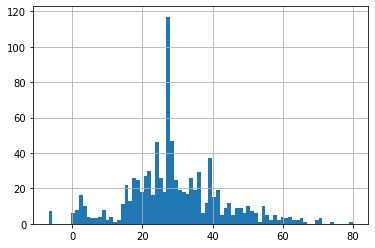

In [252]:
# Checking the Age column for potential outliers
df["Age"].hist(bins=80)

### Handling outliers in the age column

It seems there are some age values that are zero or even below it. It should be safe to assume these are outliers to be dealt with.

These outliers are most likely due to using Lr to fill the missing age values.

In [253]:
# Checking how many values are below 1
len(df[df["Age"] < 1])

14

Since there are only 14 outliers in the age column, I think it is safe to replace them in an quick and easy way to without affecting the data too much.
Also it should be noted that the Lr calculated to be on the lower side of the age spectrum, so it would be fitting to replace them with lower values instead of just using the
mean or median age. I'll replace them with the average value of the lowest 10 % excluding the outliers of course.

In [254]:
percentile_10 = df[df["Age"] > 1].quantile(0.1)
percentile_10["Age"]

16.0

In [255]:
low_age_df = df[(df["Age"] < percentile_10["Age"]) & (df["Age"] > 1.0)]
low_age_mean = low_age_df["Age"].mean()
low_age_mean

7.866526766984581

In [256]:
df.loc[df["Age"] < 1, "Age"] = low_age_mean

<AxesSubplot:>

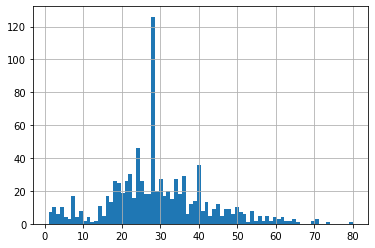

In [257]:
df["Age"].hist(bins=80)


Now that the missing values and outliers have been dealt with lets do a initial check to see if there are any columns that correlate with did the passenger survive or not. Before checking
the correlation, I'll chance the values of the "Sex" column to 0 and 1.

In [258]:
df.loc[df["Sex"] == "male", "Sex"] = 0
df.loc[df["Sex"] == "female", "Sex"] = 1
df["Sex"] = df["Sex"].astype(int)
df["Age"] = df["Age"].astype(int)

df.corr()["Survived"].sort_values(ascending=False)

Survived      1.000000
Sex           0.543351
Fare          0.257307
Parch         0.081629
FamilySize    0.016639
SibSp        -0.035322
Age          -0.042492
Pclass       -0.338481
Name: Survived, dtype: float64

There seems to be a high correlation if the passenger survived with sex, fare and Pclass.

# Predicting surviability with LogisticRegression

The accuracy of the prediction: 77.65%


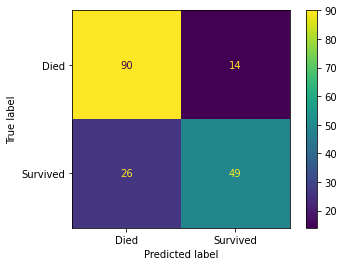

In [259]:

# Dropping columns deemed non necessary and creating a new df for the model from the remaining columns
df_logreg = df.drop(["Name", "Fare", "Embarked", "Ticket"], axis=1)

feature_cols = list(df_logreg.columns)[1:]
x = df_logreg[feature_cols]
y = df_logreg["Survived"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=60)

model = LogisticRegression()

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

# checking how the model performed with confusion matrix and accuracy score

cnf_mat = metrics.confusion_matrix(y_test, y_pred)

cnf_mat_disp = metrics.ConfusionMatrixDisplay(cnf_mat, display_labels=["Died", "Survived"])

cnf_mat_disp.plot()

accuracy = accuracy_score(y_test, y_pred)
print(f"The accuracy of the prediction: {round(accuracy * 100, 2)}%")

The logistic regression achieved a precision of 77.65% percent accuracy which is better than just predicting that every passengers died. Just predicting that the passenger died would 
result in a accuracy of aprox. 62%, in other words the mortality rate of the passengers on the Titanic.

Looking at the confusion matrix it can be noted that the model does a better job predicting if the passenger died compared to predicting if the passenger survived. The model correctly predicted that 49 passengers survived while incorrectly predicting 26 of them died. This can be due to the fact that majority of the passengers died on the Titanic, which means the dataset is not balanced. It is worth exploring could scaling the values improve the accuracy of the model.

The accuracy of the prediction: 77.09%


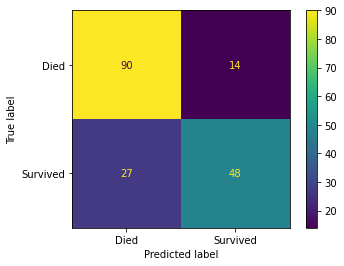

In [260]:
# Checking how scaling the values affects the accuracy of the prediction

scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

model = LogisticRegression()

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

cnf_mat = metrics.confusion_matrix(y_test, y_pred)

cnf_mat_disp = metrics.ConfusionMatrixDisplay(cnf_mat, display_labels=["Died", "Survived"])

cnf_mat_disp.plot()

accuracy = accuracy_score(y_test, y_pred)
print(f"The accuracy of the prediction: {round(accuracy * 100, 2)}%")


In this case scaling the values didnt improve the accuracy, it performed a little bit worse than without scaling as it had 1 more incorrect prediction for if the passenger survived.

# Predicting surviability with RandomForest

The accuracy of the prediction: 81.56%


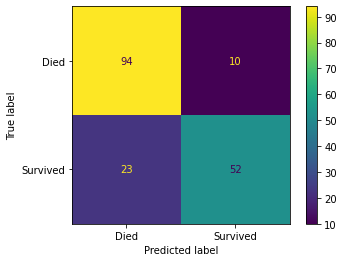

In [261]:
x = df_logreg[feature_cols] # df_logreg was created for the logistic regression, same features will be used here
y = df_logreg["Survived"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=60)

# Even though the scaling did not improve the efficiency of the Lreg model I will scale the values, since the age value is way higher than the rest of the values in feature_cols.
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

rnf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=60)
rnf.fit(x_train, y_train)
y_pred = rnf.predict(x_test)

cnf_mat = metrics.confusion_matrix(y_test, y_pred)
cnf_mat_disp = metrics.ConfusionMatrixDisplay(cnf_mat, display_labels=["Died", "Survived"])
cnf_mat_disp.plot()

accuracy = accuracy_score(y_test, y_pred)
print(f"The accuracy of the prediction: {round(accuracy * 100, 2)}%")

The random forest performed better than the Lreg model as it predicted 94 persons died and 52 persons survived correctly. But it is worth noting that, this model also strugles to predict if the passenger survived correctly.

# Predicting surviability with GradientBoosting